In [1]:
!ls

00-Task2EDA.ipynb
01-Pilot-Task-Scripts-EDA.ipynb
02-PilotTaskResultsEDA.ipynb


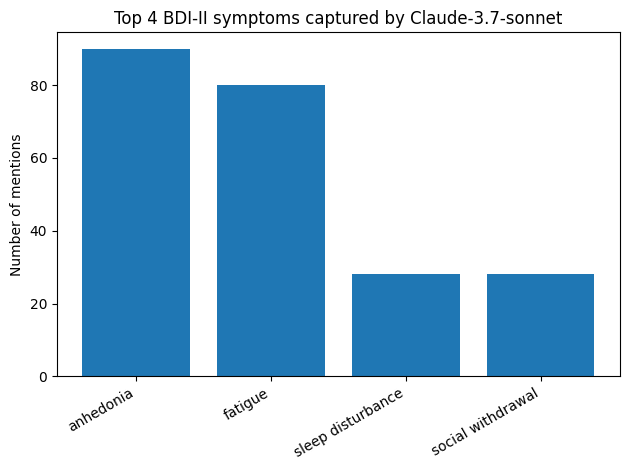

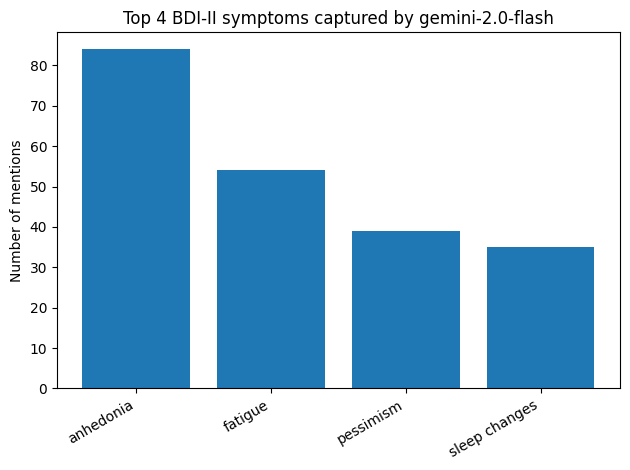

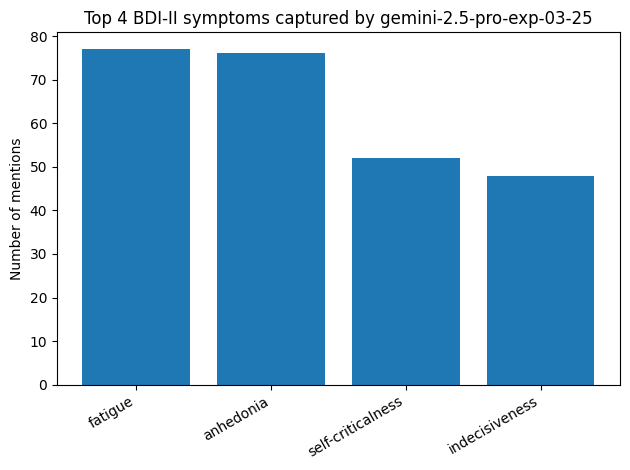

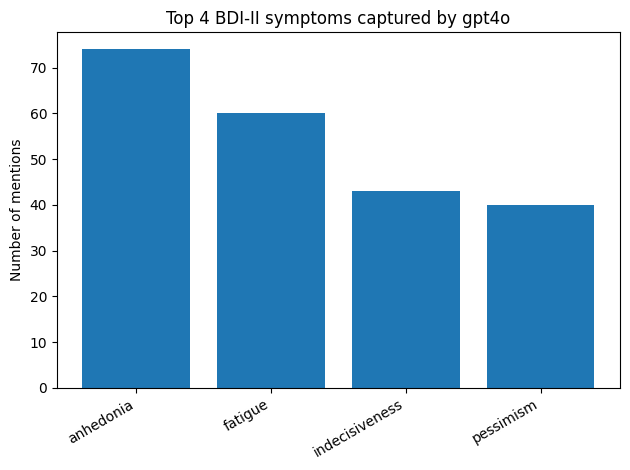

In [5]:
import pandas as pd
from pathlib import Path
import json
import re
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------
# 1.  CONFIG
# --------------------------------------------------------------------------
DATA_ROOT = Path(r"D:\SRC\DS@GT\eRisk25\erisk-2025\pilot_task\transcripts")
MODELS     = ["gpt4o", "gemini-2.5-pro-exp-03-25",
              "gemini-2.0-flash", "Claude-3.7-sonnet"]

# --------------------------------------------------------------------------
# 2.  HELPERS
# --------------------------------------------------------------------------
def load_transcripts(model_name: str,
                     data_root: Path = DATA_ROOT
                     ) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Read every *.json transcript for `model_name` and return:

    • df_turns     : one row per turn with input/output text
    • df_symptoms  : one row per *symptom mention* (long format)

    Both frames include `model` and `participant` columns for grouping.
    """
    turns_rows, symptom_rows = [], []

    for json_file in (data_root / model_name).glob("*.json"):
        with open(json_file, encoding="utf-8") as f:
            transcript = json.load(f)

        participant_id = json_file.stem
        for turn in transcript:
            # -- text -------------------------------------------------------
            input_msg  = turn.get("input_message", "")
            output_msg = turn.get("output_message", "")
            turns_rows.append(
                {
                    "model":       model_name,
                    "participant": participant_id,
                    "input":       input_msg,
                    "output":      output_msg,
                    "combined":    f"{input_msg} {output_msg}",
                    "turn_number": turn.get("turn_number", None),
                }
            )

            # -- symptoms ---------------------------------------------------
            eval_block   = turn.get("evaluation", {})
            key_symptoms = eval_block.get("key_symptoms", [])
            for s in key_symptoms:
                symptom_rows.append(
                    {
                        "model":       model_name,
                        "participant": participant_id,
                        "symptom":     s.strip().lower(),
                    }
                )

    return (pd.DataFrame(turns_rows,  dtype="string"),
            pd.DataFrame(symptom_rows, dtype="string"))

# --------------------------------------------------------------------------
# 3.  LOAD EVERYTHING
# --------------------------------------------------------------------------
df_turns_list, df_sym_list = [], []
for m in MODELS:
    tdf, sdf   = load_transcripts(m)
    df_turns_list.append(tdf)
    df_sym_list.append(sdf)

df_turns     = pd.concat(df_turns_list, ignore_index=True)
df_symptoms  = pd.concat(df_sym_list, ignore_index=True)

# --------------------------------------------------------------------------
# 4.  AGGREGATE  &  PLOT  TOP-4  SYMPTOMS  PER  MODEL
# --------------------------------------------------------------------------
sym_counts = (df_symptoms
              .groupby(["model", "symptom"])
              .size()
              .reset_index(name="count"))

for model_name, sub in sym_counts.groupby("model"):
    top4 = sub.nlargest(4, "count")
    if top4.empty:
        continue

    plt.figure()                        # ONE clear plot per model
    plt.bar(top4["symptom"], top4["count"])
    plt.title(f"Top 4 BDI-II symptoms captured by {model_name}")
    plt.ylabel("Number of mentions")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


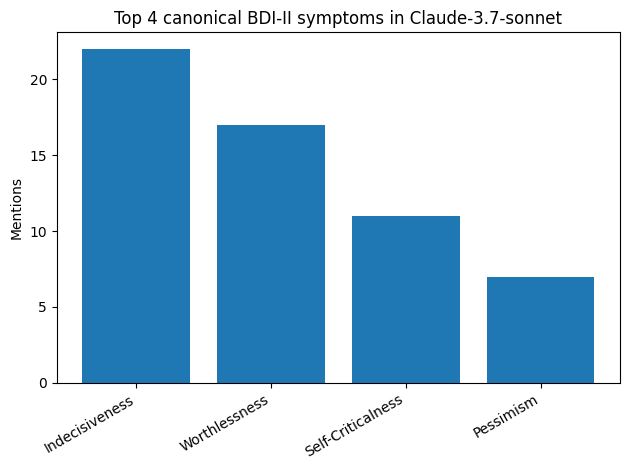

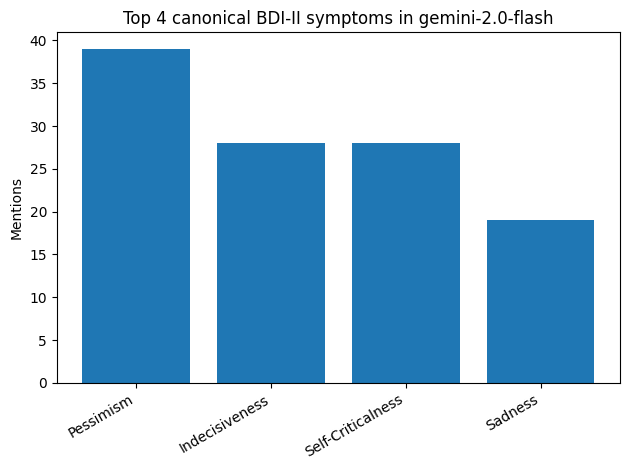

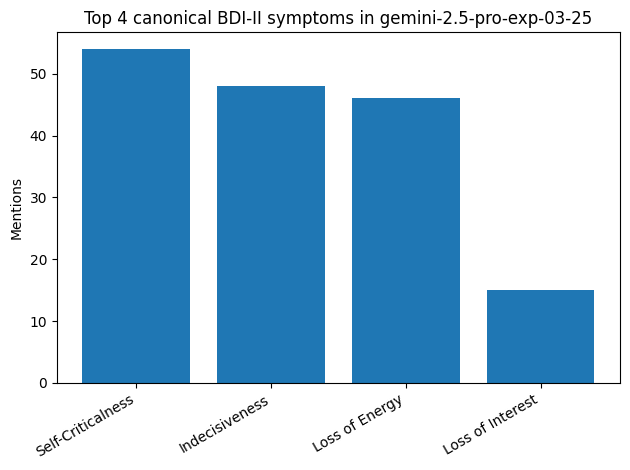

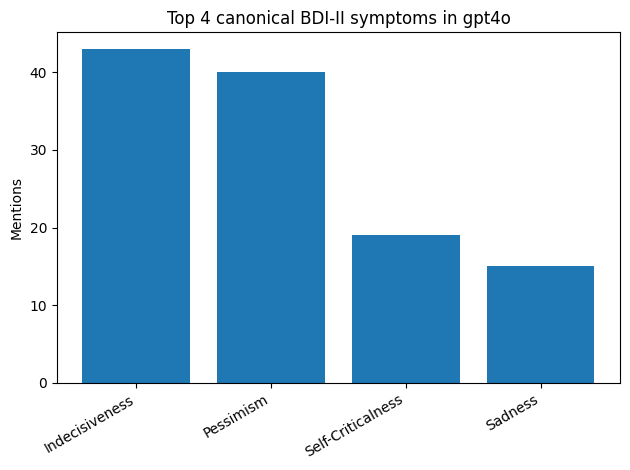

In [6]:
import pandas as pd
from pathlib import Path
import json, difflib, matplotlib.pyplot as plt

# --------------------------------------------------------------------------
# 0.  CANONICAL DEFINITIONS  (your block, unchanged)
# --------------------------------------------------------------------------
CANONICAL_SYMPTOMS = [
    "Sadness", "Pessimism", "Past Failure", "Loss of Pleasure",
    "Guilty Feelings", "Punishment Feelings", "Self-Dislike",
    "Self-Criticalness", "Suicidal Thoughts or Wishes", "Crying",
    "Agitation", "Loss of Interest", "Indecisiveness", "Worthlessness",
    "Loss of Energy", "Changes in Sleeping Pattern", "Irritability",
    "Changes in Appetite", "Concentration Difficulty",
    "Tiredness or Fatigue", "Loss of Interest in Sex"
]

SYMPTOM_MAP = {  # … full mapping omitted for brevity; keep exactly as supplied …
}
def canonicalize(symptom: str):
    sym = symptom.strip().lower()
    # 1) exact, case-insensitive
    for raw, canon in SYMPTOM_MAP.items():
        if raw.lower() == sym:
            return canon
    # 2) fuzzy vs raw keys
    close = difflib.get_close_matches(symptom, SYMPTOM_MAP.keys(), n=1, cutoff=0.75)
    if close:
        return SYMPTOM_MAP[close[0]]
    # 3) fuzzy vs canonical list
    close2 = difflib.get_close_matches(symptom, CANONICAL_SYMPTOMS, n=1, cutoff=0.75)
    if close2:
        return close2[0]
    return None
# --------------------------------------------------------------------------

# --------------------------------------------------------------------------
# 1.  CONFIG
# --------------------------------------------------------------------------
DATA_ROOT = Path(r"D:\SRC\DS@GT\eRisk25\erisk-2025\pilot_task\transcripts")
MODELS    = ["gpt4o", "gemini-2.5-pro-exp-03-25",
             "gemini-2.0-flash", "Claude-3.7-sonnet"]

# --------------------------------------------------------------------------
# 2.  LOADER  (adds canonicalisation)
# --------------------------------------------------------------------------
def load_transcripts(model_name: str, data_root: Path = DATA_ROOT):
    turns_rows, symptom_rows = [], []

    for jf in (data_root / model_name).glob("*.json"):
        with open(jf, encoding="utf-8") as f:
            transcript = json.load(f)
        participant = jf.stem

        for turn in transcript:
            inp  = turn.get("input_message", "")
            out  = turn.get("output_message", "")
            turns_rows.append({
                "model": model_name,
                "participant": participant,
                "input": inp,
                "output": out,
                "combined": f"{inp} {out}",
                "turn_number": turn.get("turn_number")
            })

            for raw_s in turn.get("evaluation", {}).get("key_symptoms", []):
                canon = canonicalize(raw_s)
                if canon:       # skip un-mappable labels
                    symptom_rows.append({
                        "model": model_name,
                        "participant": participant,
                        "symptom": canon
                    })

    return (pd.DataFrame(turns_rows,  dtype="string"),
            pd.DataFrame(symptom_rows, dtype="string"))

# --------------------------------------------------------------------------
# 3.  BUILD DATAFRAMES
# --------------------------------------------------------------------------
df_turns, df_symptoms = [], []
for m in MODELS:
    tdf, sdf = load_transcripts(m)
    df_turns.append(tdf)
    df_symptoms.append(sdf)

df_turns    = pd.concat(df_turns,    ignore_index=True)
df_symptoms = pd.concat(df_symptoms, ignore_index=True)

# --------------------------------------------------------------------------
# 4.  AGGREGATE  &  PLOT  TOP-4  CANONICAL  SYMPTOMS
# --------------------------------------------------------------------------
sym_counts = (df_symptoms
              .groupby(["model", "symptom"])
              .size()
              .reset_index(name="count"))

for model, sub in sym_counts.groupby("model"):
    top4 = sub.nlargest(4, "count")
    if top4.empty:
        continue
    plt.figure()                    # one figure per model, no custom colours
    plt.bar(top4["symptom"], top4["count"])
    plt.title(f"Top 4 canonical BDI-II symptoms in {model}")
    plt.ylabel("Mentions")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


In [9]:
import pandas as pd
from pathlib import Path
import json, difflib, matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# 0. CANONICAL LIST & YOUR EXACT SYMPTOM_MAP
# -------------------------------------------------------------------------
CANONICAL_SYMPTOMS = [
    "Sadness", "Pessimism", "Past Failure", "Loss of Pleasure",
    "Guilty Feelings", "Punishment Feelings", "Self-Dislike",
    "Self-Criticalness", "Suicidal Thoughts or Wishes", "Crying",
    "Agitation", "Loss of Interest", "Indecisiveness", "Worthlessness",
    "Loss of Energy", "Changes in Sleeping Pattern", "Irritability",
    "Changes in Appetite", "Concentration Difficulty",
    "Tiredness or Fatigue", "Loss of Interest in Sex"
]

SYMPTOM_MAP = {       #  ←←  block kept verbatim
    "Sadness": "Sadness",
    "Pessimism": "Pessimism",
    "Pessimism/Hopelessness": "Pessimism",
    "Hopelessness": "Pessimism",
    "Sense of Failure": "Past Failure",
    "Past Failure": "Past Failure",
    "Failure": "Past Failure",
    "Anhedonia": "Loss of Pleasure",
    "Anhedonia/Disconnection": "Loss of Pleasure",
    "Loss of Pleasure": "Loss of Pleasure",
    "Lack of Satisfaction": "Loss of Pleasure",
    "Emotional Suppression": "Loss of Pleasure",
    "Loss of Interest": "Loss of Interest",
    "Loss of Interest Social": "Loss of Interest",
    "Loss Of Social Interest": "Loss of Interest",
    "Social Withdrawal": "Loss of Interest",
    "Social Disinterest": "Loss of Interest",
    "Guilty Feelings": "Guilty Feelings",
    "Guilt": "Guilty Feelings",
    "Punishment Feelings": "Punishment Feelings",
    "Self-Dislike": "Self-Dislike",
    "Self Dislike": "Self-Dislike",
    "Self-Criticism": "Self-Criticalness",
    "Self-Criticalness": "Self-Criticalness",
    "Self-Criticalness/Worthlessness": "Self-Criticalness",
    "Suicidal Thoughts": "Suicidal Thoughts or Wishes",
    "Suicidal Thoughts or Wishes": "Suicidal Thoughts or Wishes",
    "Crying": "Crying",
    "Agitation": "Agitation",
    "Indecisiveness": "Indecisiveness",
    "Worthlessness": "Worthlessness",
    "Depersonalization": "Loss of Pleasure",
    "Loss of Energy": "Loss of Energy",
    "Fatigue/Loss Of Energy": "Loss of Energy",
    "Mild Fatigue": "Tiredness or Fatigue",
    "Fatigue": "Tiredness or Fatigue",
    "Tiredness or Fatigue": "Tiredness or Fatigue",
    "Changes in Sleep": "Changes in Sleeping Pattern",
    "Changes in Sleeping Pattern": "Changes in Sleeping Pattern",
    "Sleep Disturbance": "Changes in Sleeping Pattern",
    "Sleep Changes": "Changes in Sleeping Pattern",
    "Sleep Problems": "Changes in Sleeping Pattern",
    "Mild Sleep Disturbance": "Changes in Sleeping Pattern",
    "Changes in Appetite": "Changes in Appetite",
    "Appetite/Weight Changes": "Changes in Appetite",
    "Appetite Changes": "Changes in Appetite",
    "Concentration Problems": "Concentration Difficulty",
    "Concentration Difficulty": "Concentration Difficulty",
    "Diminished Concentration": "Concentration Difficulty",
    "Irritability": "Irritability",
    "Loss of Interest in Sex": "Loss of Interest in Sex"
}

def canonicalize(symptom: str):
    sym = symptom.strip().lower()
    for raw, canon in SYMPTOM_MAP.items():
        if raw.lower() == sym:
            return canon
    close = difflib.get_close_matches(symptom, SYMPTOM_MAP.keys(), n=1, cutoff=0.75)
    if close:
        return SYMPTOM_MAP[close[0]]
    close2 = difflib.get_close_matches(symptom, CANONICAL_SYMPTOMS, n=1, cutoff=0.75)
    if close2:
        return close2[0]
    return None
# -------------------------------------------------------------------------

# -------------------------------------------------------------------------
# 1. CONFIG
# -------------------------------------------------------------------------
DATA_ROOT = Path(r"D:\SRC\DS@GT\eRisk25\erisk-2025\pilot_task\transcripts")
MODELS    = [
    "gpt4o",
    "gemini-2.5-pro-exp-03-25",
    "gemini-2.0-flash",
    "Claude-3.7-sonnet"
]

# -------------------------------------------------------------------------
# 2. LOAD TRANSCRIPTS (NO CANONICALISATION YET)
# -------------------------------------------------------------------------
def load_transcripts(model_name: str):
    rows = []
    for jf in (DATA_ROOT / model_name).glob("*.json"):
        with open(jf, encoding="utf-8") as f:
            transcript = json.load(f)
        participant = jf.stem
        for turn in transcript:
            rows.append({
                "model": model_name,
                "participant": participant,
                "turn_number": turn.get("turn_number"),
                "symptom_raw_list": turn.get("evaluation", {}).get("key_symptoms", [])
            })
    return pd.DataFrame(rows, dtype="string")

df_all = pd.concat([load_transcripts(m) for m in MODELS], ignore_index=True)
df_all["turn_number"] = pd.to_numeric(df_all["turn_number"])

# -------------------------------------------------------------------------
# 3. SELECT TARGET TURN PER CONVERSATION
#    • If turn 20 exists → use it
#    • Otherwise → use the highest turn number available
# -------------------------------------------------------------------------
def choose_target(group):
    if 20 in group["turn_number"].values:
        return group[group["turn_number"] == 20]
    return group[group["turn_number"] == group["turn_number"].max()]

df_target = (
    df_all.groupby(["model", "participant"], group_keys=False)
          .apply(choose_target)
          .explode("symptom_raw_list")          # one row per raw label
          .rename(columns={"symptom_raw_list": "symptom_raw"})
)

# -------------------------------------------------------------------------
# 4. CANONICALISE & DROP UNMAPPED
# -------------------------------------------------------------------------
df_target["symptom"] = df_target["symptom_raw"].apply(canonicalize)
df_target = df_target[df_target["symptom"].notna()]

# -------------------------------------------------------------------------
# 5. AGGREGATE & PLOT (TOP-4 PER MODEL)
# -------------------------------------------------------------------------
sym_counts = (
    df_target.groupby(["model", "symptom"])
             .size()
             .reset_index(name="count")
)

for model, sub in sym_counts.groupby("model"):
    top4 = sub.nlargest(4, "count")
    if top4.empty:
        continue

    plt.figure()                       # one bar chart per model
    plt.bar(top4["symptom"], top4["count"])
    plt.title(f"Top 4 BDI-II symptoms by turn 20 (or last) — {model}")
    plt.ylabel("Mentions")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


In [11]:
df_all

,model,participant,turn_number,symptom_raw_list
0,gpt4o,alex,1.0,[]
1,gpt4o,alex,2.0,"['Indecisiveness', 'Fatigue', 'Sleep Changes']"
2,gpt4o,alex,3.0,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
3,gpt4o,alex,4.0,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
4,gpt4o,alex,5.0,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
...,...,...,...,...
519,Claude-3.7-sonnet,priya,<NA>,"['mild sleep disturbance', 'mild fatigue']"
520,Claude-3.7-sonnet,priya,<NA>,"['mild sleep disturbance', 'mild fatigue']"
521,Claude-3.7-sonnet,priya,<NA>,"['mild sleep disturbance', 'mild fatigue']"
522,Claude-3.7-sonnet,priya,<NA>,"['mild sleep disturbance', 'mild fatigue']"


In [12]:
import pandas as pd
from pathlib import Path
import json, difflib, matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# 0.  CANONICAL LIST  +  YOUR EXACT SYMPTOM_MAP  (unchanged)
# -------------------------------------------------------------------------
CANONICAL_SYMPTOMS = [
    "Sadness", "Pessimism", "Past Failure", "Loss of Pleasure",
    "Guilty Feelings", "Punishment Feelings", "Self-Dislike",
    "Self-Criticalness", "Suicidal Thoughts or Wishes", "Crying",
    "Agitation", "Loss of Interest", "Indecisiveness", "Worthlessness",
    "Loss of Energy", "Changes in Sleeping Pattern", "Irritability",
    "Changes in Appetite", "Concentration Difficulty",
    "Tiredness or Fatigue", "Loss of Interest in Sex"
]

SYMPTOM_MAP = {   # … verbatim block kept intact …
    "Sadness": "Sadness",
    "Pessimism": "Pessimism",
    "Pessimism/Hopelessness": "Pessimism",
    "Hopelessness": "Pessimism",
    "Sense of Failure": "Past Failure",
    "Past Failure": "Past Failure",
    "Failure": "Past Failure",
    "Anhedonia": "Loss of Pleasure",
    "Anhedonia/Disconnection": "Loss of Pleasure",
    "Loss of Pleasure": "Loss of Pleasure",
    "Lack of Satisfaction": "Loss of Pleasure",
    "Emotional Suppression": "Loss of Pleasure",
    "Loss of Interest": "Loss of Interest",
    "Loss of Interest Social": "Loss of Interest",
    "Loss Of Social Interest": "Loss of Interest",
    "Social Withdrawal": "Loss of Interest",
    "Social Disinterest": "Loss of Interest",
    "Guilty Feelings": "Guilty Feelings",
    "Guilt": "Guilty Feelings",
    "Punishment Feelings": "Punishment Feelings",
    "Self-Dislike": "Self-Dislike",
    "Self Dislike": "Self-Dislike",
    "Self-Criticism": "Self-Criticalness",
    "Self-Criticalness": "Self-Criticalness",
    "Self-Criticalness/Worthlessness": "Self-Criticalness",
    "Suicidal Thoughts": "Suicidal Thoughts or Wishes",
    "Suicidal Thoughts or Wishes": "Suicidal Thoughts or Wishes",
    "Crying": "Crying",
    "Agitation": "Agitation",
    "Indecisiveness": "Indecisiveness",
    "Worthlessness": "Worthlessness",
    "Depersonalization": "Loss of Pleasure",
    "Loss of Energy": "Loss of Energy",
    "Fatigue/Loss Of Energy": "Loss of Energy",
    "Mild Fatigue": "Tiredness or Fatigue",
    "Fatigue": "Tiredness or Fatigue",
    "Tiredness or Fatigue": "Tiredness or Fatigue",
    "Changes in Sleep": "Changes in Sleeping Pattern",
    "Changes in Sleeping Pattern": "Changes in Sleeping Pattern",
    "Sleep Disturbance": "Changes in Sleeping Pattern",
    "Sleep Changes": "Changes in Sleeping Pattern",
    "Sleep Problems": "Changes in Sleeping Pattern",
    "Mild Sleep Disturbance": "Changes in Sleeping Pattern",
    "Changes in Appetite": "Changes in Appetite",
    "Appetite/Weight Changes": "Changes in Appetite",
    "Appetite Changes": "Changes in Appetite",
    "Concentration Problems": "Concentration Difficulty",
    "Concentration Difficulty": "Concentration Difficulty",
    "Diminished Concentration": "Concentration Difficulty",
    "Irritability": "Irritability",
    "Loss of Interest in Sex": "Loss of Interest in Sex"
}

def canonicalize(s: str):
    s_l = s.strip().lower()
    for raw, canon in SYMPTOM_MAP.items():
        if raw.lower() == s_l:
            return canon
    near = difflib.get_close_matches(s, SYMPTOM_MAP.keys(), n=1, cutoff=0.75)
    if near:
        return SYMPTOM_MAP[near[0]]
    near2 = difflib.get_close_matches(s, CANONICAL_SYMPTOMS, n=1, cutoff=0.75)
    return near2[0] if near2 else None
# -------------------------------------------------------------------------

# -------------------------------------------------------------------------
# 1.  CONFIG
# -------------------------------------------------------------------------
DATA_ROOT = Path(r"D:\SRC\DS@GT\eRisk25\erisk-2025\pilot_task\transcripts")
MODELS    = ["gpt4o",
             "gemini-2.5-pro-exp-03-25",
             "gemini-2.0-flash",
             "Claude-3.7-sonnet"]

# -------------------------------------------------------------------------
# 2.  LOAD: get assessment_turn from evaluation{…}
# -------------------------------------------------------------------------
def load_model(model_name: str):
    rows = []
    for fp in (DATA_ROOT / model_name).glob("*.json"):
        with open(fp, encoding="utf-8") as f:
            transcript = json.load(f)
        participant = fp.stem

        for idx, turn in enumerate(transcript, 1):            # idx is a fallback order
            ev = turn.get("evaluation", {})
            rows.append({
                "model": model_name,
                "participant": participant,
                "row_order": idx,                             # fallback ordering
                "assessment_turn": ev.get("assessment_turn"),
                "symptom_raw_list": ev.get("key_symptoms", [])
            })
    return pd.DataFrame(rows, dtype="string")

df = pd.concat([load_model(m) for m in MODELS], ignore_index=True)
df["assessment_turn"] = pd.to_numeric(df["assessment_turn"])  # NaN if missing

# -------------------------------------------------------------------------
# 4.  CANONICALISE & FILTER
# -------------------------------------------------------------------------
df_target["symptom"] = df_target["symptom_raw"].apply(canonicalize)
df_target = df_target[df_target["symptom"].notna()]

# -------------------------------------------------------------------------
# 5.  COUNT & PLOT
# -------------------------------------------------------------------------
counts = (df_target.groupby(["model", "symptom"])
                   .size()
                   .reset_index(name="count"))

for model, sub in counts.groupby("model"):
    top4 = sub.nlargest(4, "count")
    if top4.empty:
        continue
    plt.figure()
    plt.bar(top4["symptom"], top4["count"])
    plt.title(f"Top 4 BDI-II symptoms @ turn 20 (or last) — {model}")
    plt.ylabel("Mentions")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


In [20]:
df.head(25)

,model,participant,row_order,assessment_turn,symptom_raw_list
0,gpt4o,alex,1,1,[]
1,gpt4o,alex,2,2,"['Indecisiveness', 'Fatigue', 'Sleep Changes']"
2,gpt4o,alex,3,3,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
3,gpt4o,alex,4,4,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
4,gpt4o,alex,5,5,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
5,gpt4o,alex,6,6,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
6,gpt4o,alex,7,8,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
7,gpt4o,alex,8,9,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
8,gpt4o,alex,9,10,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."
9,gpt4o,alex,10,11,"['Indecisiveness', 'Fatigue', 'Sleep Changes',..."


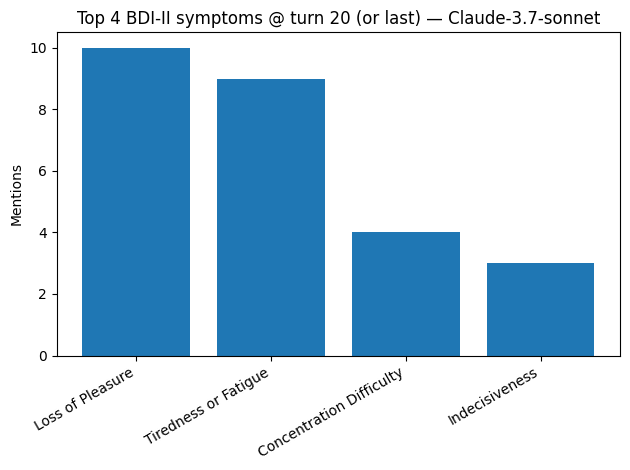

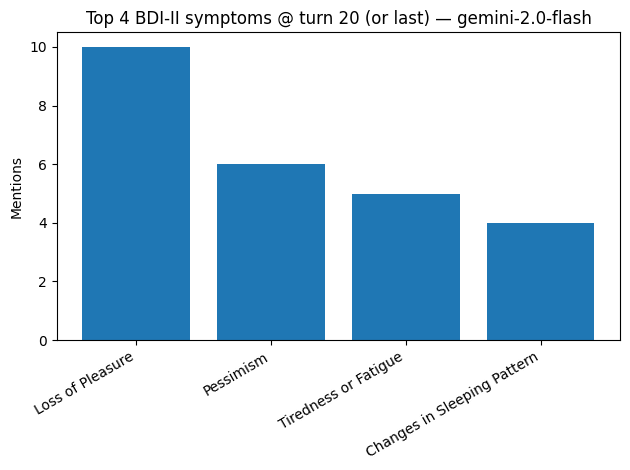

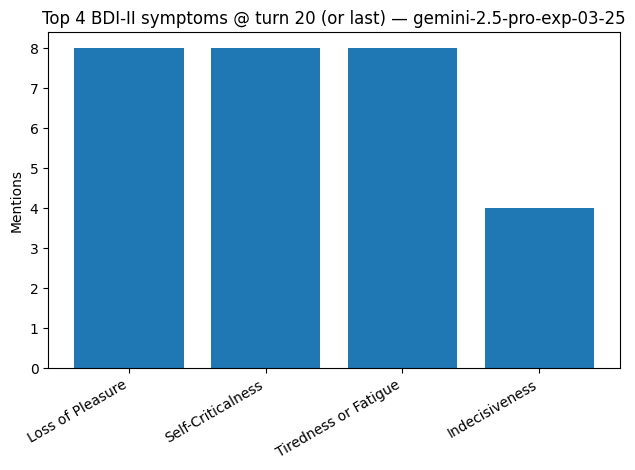

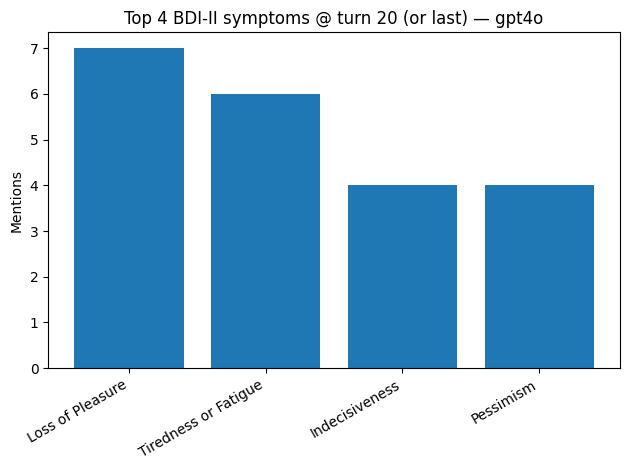

In [22]:
import pandas as pd
from pathlib import Path
import json, difflib, matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# 0.  CANONICAL LIST  +  YOUR EXACT SYMPTOM_MAP  (unchanged)
# -------------------------------------------------------------------------
CANONICAL_SYMPTOMS = [
    "Sadness", "Pessimism", "Past Failure", "Loss of Pleasure",
    "Guilty Feelings", "Punishment Feelings", "Self-Dislike",
    "Self-Criticalness", "Suicidal Thoughts or Wishes", "Crying",
    "Agitation", "Loss of Interest", "Indecisiveness", "Worthlessness",
    "Loss of Energy", "Changes in Sleeping Pattern", "Irritability",
    "Changes in Appetite", "Concentration Difficulty",
    "Tiredness or Fatigue", "Loss of Interest in Sex"
]

SYMPTOM_MAP = {  #  your block verbatim
    "Sadness": "Sadness",
    "Pessimism": "Pessimism",
    "Pessimism/Hopelessness": "Pessimism",
    "Hopelessness": "Pessimism",
    "Sense of Failure": "Past Failure",
    "Past Failure": "Past Failure",
    "Failure": "Past Failure",
    "Anhedonia": "Loss of Pleasure",
    "Anhedonia/Disconnection": "Loss of Pleasure",
    "Loss of Pleasure": "Loss of Pleasure",
    "Lack of Satisfaction": "Loss of Pleasure",
    "Emotional Suppression": "Loss of Pleasure",
    "Loss of Interest": "Loss of Interest",
    "Loss of Interest Social": "Loss of Interest",
    "Loss Of Social Interest": "Loss of Interest",
    "Social Withdrawal": "Loss of Interest",
    "Social Disinterest": "Loss of Interest",
    "Guilty Feelings": "Guilty Feelings",
    "Guilt": "Guilty Feelings",
    "Punishment Feelings": "Punishment Feelings",
    "Self-Dislike": "Self-Dislike",
    "Self Dislike": "Self-Dislike",
    "Self-Criticism": "Self-Criticalness",
    "Self-Criticalness": "Self-Criticalness",
    "Self-Criticalness/Worthlessness": "Self-Criticalness",
    "Suicidal Thoughts": "Suicidal Thoughts or Wishes",
    "Suicidal Thoughts or Wishes": "Suicidal Thoughts or Wishes",
    "Crying": "Crying",
    "Agitation": "Agitation",
    "Indecisiveness": "Indecisiveness",
    "Worthlessness": "Worthlessness",
    "Depersonalization": "Loss of Pleasure",
    "Loss of Energy": "Loss of Energy",
    "Fatigue/Loss Of Energy": "Loss of Energy",
    "Mild Fatigue": "Tiredness or Fatigue",
    "Fatigue": "Tiredness or Fatigue",
    "Tiredness or Fatigue": "Tiredness or Fatigue",
    "Changes in Sleep": "Changes in Sleeping Pattern",
    "Changes in Sleeping Pattern": "Changes in Sleeping Pattern",
    "Sleep Disturbance": "Changes in Sleeping Pattern",
    "Sleep Changes": "Changes in Sleeping Pattern",
    "Sleep Problems": "Changes in Sleeping Pattern",
    "Mild Sleep Disturbance": "Changes in Sleeping Pattern",
    "Changes in Appetite": "Changes in Appetite",
    "Appetite/Weight Changes": "Changes in Appetite",
    "Appetite Changes": "Changes in Appetite",
    "Concentration Problems": "Concentration Difficulty",
    "Concentration Difficulty": "Concentration Difficulty",
    "Diminished Concentration": "Concentration Difficulty",
    "Irritability": "Irritability",
    "Loss of Interest in Sex": "Loss of Interest in Sex"
}

def canonicalize(label):
    """Map raw label → canonical name, or None if unmappable / not a string."""
    if not isinstance(label, str):
        return None                       # handles NaN or other non-str types
    l = label.strip().lower()
    for raw, canon in SYMPTOM_MAP.items():
        if raw.lower() == l:
            return canon
    near = difflib.get_close_matches(label, SYMPTOM_MAP.keys(), n=1, cutoff=0.75)
    if near:
        return SYMPTOM_MAP[near[0]]
    near2 = difflib.get_close_matches(label, CANONICAL_SYMPTOMS, n=1, cutoff=0.75)
    return near2[0] if near2 else None
    
# -------------------------------------------------------------------------
# 1.  CONFIG
# -------------------------------------------------------------------------
DATA_ROOT = Path(r"D:\SRC\DS@GT\eRisk25\erisk-2025\pilot_task\transcripts")
MODELS    = ["gpt4o",
             "gemini-2.5-pro-exp-03-25",
             "gemini-2.0-flash",
             "Claude-3.7-sonnet"]

# -------------------------------------------------------------------------
# 2.  LOAD JSONS  (lists stay as lists)
# -------------------------------------------------------------------------
def load_model(model_name: str) -> pd.DataFrame:
    rows = []
    for fp in (DATA_ROOT / model_name).glob("*.json"):
        with open(fp, encoding="utf-8") as f:
            transcript = json.load(f)
        participant = fp.stem
        for idx, turn in enumerate(transcript, 1):   # idx: fallback order
            ev = turn.get("evaluation", {})
            rows.append(
                {
                    "model": model_name,
                    "participant": participant,
                    "row_order": idx,
                    "assessment_turn": ev.get("assessment_turn"),
                    "symptom_raw_list": ev.get("key_symptoms", [])
                }
            )
    return pd.DataFrame(rows)       # keep default "object" dtype (lists intact)

df = pd.concat([load_model(m) for m in MODELS], ignore_index=True)
df["assessment_turn"] = pd.to_numeric(df["assessment_turn"])  # NaN allowed

# -------------------------------------------------------------------------
# 3.  SELECT 1 TURN PER CONVERSATION  (20 if present else latest)
# -------------------------------------------------------------------------
def choose_turn(group: pd.DataFrame) -> pd.DataFrame:
    """Return the row(s) to use for this (model, participant)."""
    if 20 in group["assessment_turn"].values:
        return group[group["assessment_turn"] == 20]
    if group["assessment_turn"].notna().any():
        max_turn = group["assessment_turn"].max()
        return group[group["assessment_turn"] == max_turn]
    # all NaN → use the last row by row_order
    return group[group["row_order"] == group["row_order"].max()]

# --- after explode(), drop NaNs before mapping ----------------------------
df_target = (
    df.groupby(["model", "participant"], group_keys=False)
      .apply(choose_turn)
      .explode("symptom_raw_list")
      .rename(columns={"symptom_raw_list": "symptom_raw"})
      .dropna(subset=["symptom_raw"])          # ← NEW: remove blank rows
)

# -------------------------------------------------------------------------
# 4.  CANONICALISE & DROP UNMAPPED
# -------------------------------------------------------------------------
df_target["symptom"] = df_target["symptom_raw"].apply(canonicalize)
df_target = df_target[df_target["symptom"].notna()]

# -------------------------------------------------------------------------
# 5.  AGGREGATE  &  PLOT
# -------------------------------------------------------------------------
counts = (
    df_target.groupby(["model", "symptom"])
             .size()
             .reset_index(name="count")
)

for model, sub in counts.groupby("model"):
    top4 = sub.nlargest(4, "count")
    if top4.empty:
        continue
    plt.figure()
    plt.bar(top4["symptom"], top4["count"])
    plt.title(f"Top 4 BDI-II symptoms @ turn 20 (or last) — {model}")
    plt.ylabel("Mentions")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


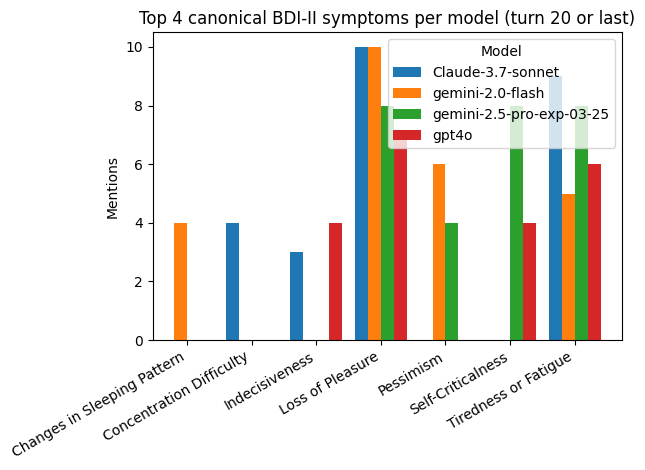

In [23]:
# -------------------------------------------------------------------------
# 4.  CANONICALISE & FILTER  (unchanged safety checks)
# -------------------------------------------------------------------------
df_target["symptom"] = df_target["symptom_raw"].apply(canonicalize)
df_target = df_target[df_target["symptom"].notna()]

# -------------------------------------------------------------------------
# 5.  AGGREGATE  &  SINGLE PLOT WITH LEGEND
# -------------------------------------------------------------------------
# a) counts per model × symptom
counts = (
    df_target.groupby(["model", "symptom"])
             .size()
             .reset_index(name="count")
)

# b) keep top-4 symptoms within each model
top4_each = (
    counts.sort_values("count", ascending=False)
          .groupby("model")
          .head(4)
)

# c) union of those symptoms for the shared x-axis
sym_union = sorted(top4_each["symptom"].unique())

# d) build a matrix: rows = models, cols = symptoms (missing → 0)
plot_df = (
    top4_each.pivot(index="model", columns="symptom", values="count")
             .reindex(columns=sym_union, fill_value=0)
)

# e) GROUPED-BAR PLOT ------------------------------------------------------
import numpy as np
fig, ax = plt.subplots()          # one figure, one axis

x = np.arange(len(sym_union))     # symptom positions
bar_w = 0.8 / len(plot_df.index)  # total width 80% of space

for i, (model, row) in enumerate(plot_df.iterrows()):
    ax.bar(x + i*bar_w, row.values, width=bar_w, label=model)

ax.set_xticks(x + bar_w*(len(plot_df.index)-1)/2)
ax.set_xticklabels(sym_union, rotation=30, ha="right")
ax.set_ylabel("Mentions")
ax.set_title("Top 4 canonical BDI-II symptoms per model (turn 20 or last)")
ax.legend(title="Model")
plt.tight_layout()
plt.show()

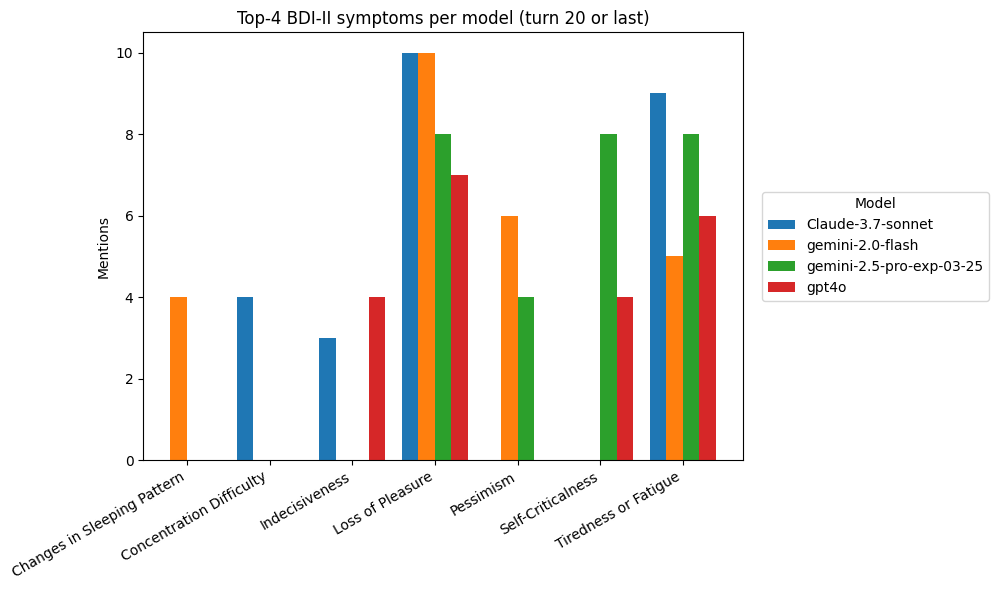

In [26]:
import numpy as np
fig, ax = plt.subplots(figsize=(10, 6))   # a bit wider for readability

x = np.arange(len(sym_union))              # positions of symptoms on x-axis
bar_w = 0.8 / len(plot_df.index)           # 80 % total width divided by #models

for i, (model, row) in enumerate(plot_df.iterrows()):
    ax.bar(x + i * bar_w, row.values, width=bar_w, label=model)

ax.set_xticks(x + bar_w * (len(plot_df.index) - 1) / 2)
ax.set_xticklabels(sym_union, rotation=30, ha="right")
ax.set_ylabel("Mentions")
ax.set_title("Top-4 BDI-II symptoms per model (turn 20 or last)")

# ⬇️  move legend to the right of the plot
ax.legend(title="Model", loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()

plt.savefig('top4permodel.png')
plt.show()

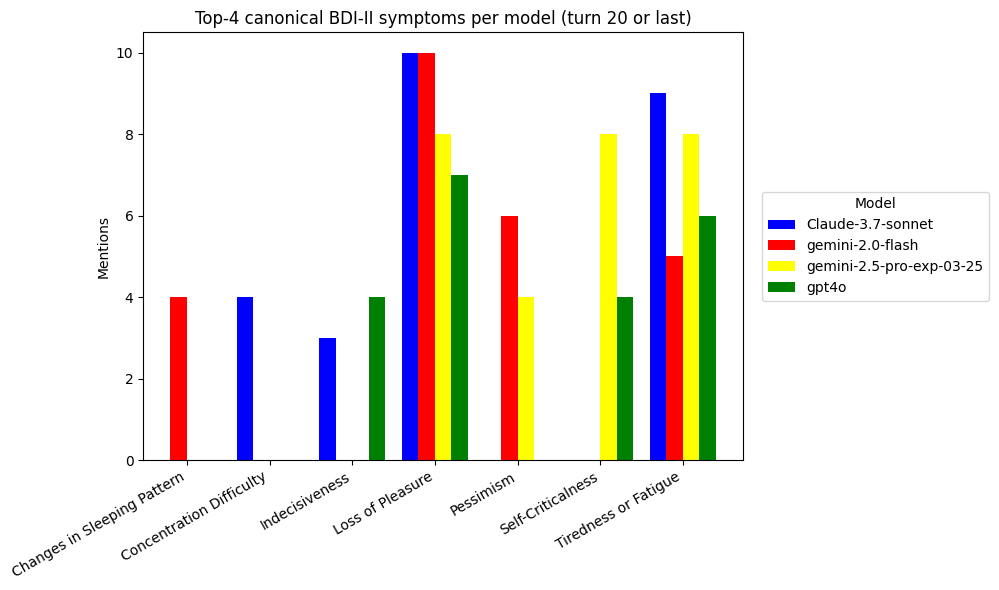

In [27]:
# e) GROUPED-BAR PLOT ------------------------------------------------------
import numpy as np
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(sym_union))
bar_w = 0.8 / len(plot_df.index)

# --- fixed colour convention ---------------------------------------------
color_map = {
    "Claude-3.7-sonnet": "blue",
    "gemini-2.0-flash":  "red",
    "gemini-2.5-pro-exp-03-25": "yellow",
    "gpt4o": "green",
}
# --------------------------------------------------------------------------

for i, (model, row) in enumerate(plot_df.iterrows()):
    ax.bar(
        x + i * bar_w,
        row.values,
        width=bar_w,
        label=model,
        color=color_map.get(model, None)  # fallback to default if model missing
    )

ax.set_xticks(x + bar_w * (len(plot_df.index) - 1) / 2)
ax.set_xticklabels(sym_union, rotation=30, ha="right")
ax.set_ylabel("Mentions")
ax.set_title("Top-4 canonical BDI-II symptoms per model (turn 20 or last)")

ax.legend(title="Model", loc="center left", bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.savefig('top4permodelv2.png')
plt.show()